# Heteroskedasticity-Robust Serial Correlation Test — Size Demo

**Goal.** Show that under **conditional heteroskedasticity** (ARCH/GARCH) with *no true serial correlation*,  
the classical **Ljung–Box** portmanteau test can be **mis-sized** (over-rejects at 5%),  
while the **Escanciano–Lobato (heteroskedasticity-robust)** test maintains nominal size.

---

**Design (high level):**
- Simulate a zero-mean **GARCH(1,1)** process: levels have no linear autocorrelation, but variance is time-varying.
- For each replication, compute residuals (here just the simulated series) and test serial correlation with:
  - **Ljung–Box (LB)** at α = 0.05
  - **Escanciano–Lobato (EL)** robust test at α = 0.05
- Repeat many times and estimate **empirical size** = rejection frequency under the true null.

---

**Output:**
- A small table comparing empirical size (LB vs EL) at 5%.
- A 5-bar figure visualizing the results (LB vs EL empirical size).

---

**Why this matters:**  
Many pipelines apply LB on heteroskedastic residuals and trust the p-values.  
This demo visualizes **why that’s unsafe** and when a **robust alternative** is needed.

### Simulation Setup

We generate synthetic data under a GARCH(1,1) process.  
This design ensures there is *no linear autocorrelation*, but the innovations are conditionally heteroskedastic.  

If a test rejects too often under this null, it indicates that the test is not robust to heteroskedasticity.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from rust_timeseries.statistical_tests import EscancianoLobato

def simulate_garch_1_1(n: int, seed: int, burnin: int = 200, omega: float = 1e-4, alpha_g: float = 0.05, beta_g: float = 0.90):
    """
    Simulate x_t with zero mean and conditional variance following GARCH(1,1):
        h_t = omega + alpha_g * u_{t-1}^2 + beta_g * h_{t-1}
        u_t ~ N(0, h_t) conditioned on current information
        x_t = u_t
    Returns an array of length n (post-burn-in).
    """
    rng = np.random.default_rng(seed)
    normal = rng.standard_normal

    T = n + burnin
    x = np.zeros(T)
    h = np.zeros(T)
    u = np.zeros(T)

    # Initialize variance at unconditional variance if stationary, else small positive
    if alpha_g + beta_g < 1:
        h0 = omega / (1 - alpha_g - beta_g)
    else:
        h0 = 1e-3
    h[0] = h0
    u[0] = np.sqrt(h[0]) * normal()
    x[0] = u[0]

    for t in range(1, T):
        h[t] = omega + alpha_g * (u[t-1]**2) + beta_g * h[t-1]
        u[t] = np.sqrt(h[t]) * normal()
        x[t] = u[t]

    return x[burnin:]

### Running the Monte Carlo Experiment

We replicate the process many times.  
For each sample, we apply both the Escanciano–Lobato (EL) test and the Ljung–Box (LB) test, recording whether they reject the null of no serial correlation at the 5% level.
Since the Ljung–Box test requires a predetermined lag number we run it with several different options and aggragate the results per option.

In [3]:
from joblib import Parallel, delayed
def run_simulation(
        n_rep: int = 50000,
        n_obs: int = 10000,
        alpha: float = 0.05,
        base_seed: int | None = 42,
        n_jobs: int = -1,
    ) -> pd.DataFrame:
    """
    Monte Carlo for empirical size under a GARCH(1,1) null.
    Returns a DataFrame with columns: ['EL','LB(5)','LB(10)','LB(15)','LB(sqrt)'].
    """

    # Generate seed sequence.
    if base_seed is None:
        seed_ints = np.random.SeedSequence().generate_state(n_rep)
    else:
        ss = np.random.SeedSequence(base_seed)
        seed_ints = [int(s.generate_state(1)[0]) for s in ss.spawn(n_rep)]

    lb_lag_grid = [5, 10, 15]
    lb_sqrt = int(np.sqrt(n_obs))
                  
    def _one(seed):
        x = simulate_garch_1_1(n_obs, seed)

        # EL (auto-lag)
        el_p: float = EscancianoLobato(x).pvalue
        row = {'EL': int(el_p < alpha)}

        # LB at conventional lags.
        for m in lb_lag_grid:
            p = acorr_ljungbox(x, lags=[m], return_df=True)['lb_pvalue'].iloc[-1]
            row[f'LB({m})'] = int(p < alpha)
        p = acorr_ljungbox(x, lags=lb_sqrt, return_df=True)['lb_pvalue'].iloc[-1]
        row['LB(sqrt)'] = int(p < alpha)

        return row

    if n_jobs == 1:
        rows = [_one(s) for s in seed_ints]
    else:
        rows = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
            delayed(_one)(s) for s in seed_ints
        )

    results = pd.DataFrame(rows, columns=["EL","LB(5)","LB(10)","LB(15)","LB(sqrt)"])
    return results

results = run_simulation()

### Empirical Rejection Rates

After completing all replications, we calculate the proportion of times each test rejected.  
This provides an estimate of the **empirical size** of each test under conditional heteroskedasticity.

In [4]:
summary = (
    results.mean(numeric_only=True)
    .to_frame('empirical_size')
    .assign(n_rep=len(results), alpha=0.05)
)
summary

,empirical_size,n_rep,alpha
EL,0.05220,50000,0.05
LB(5),0.08524,50000,0.05
LB(10),0.09308,50000,0.05
LB(15),0.09608,50000,0.05
LB(sqrt),0.08144,50000,0.05


## Visualizing the Results

To better illustrate the performance of the tests, we plot a histogram to visualize empirical size (rejection frequency) and include a dashed line at the nominal 5%. 
This highlights the tendency of LB to over-reject relative to the robust EL test.

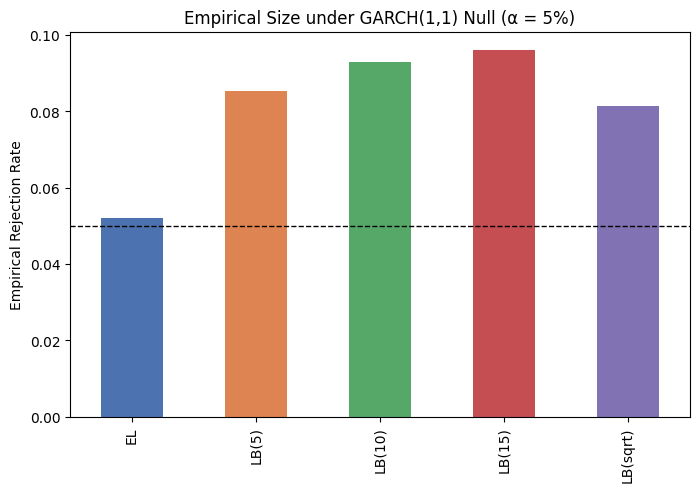

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
results.mean().plot.bar(ax=ax, color=["#4c72b0", "#dd8452", "#55a868", "#c44e52", "#8172b3"])
ax.axhline(y=0.05, color="black", linestyle="--", linewidth=1)
ax.set_ylabel("Empirical Rejection Rate")
ax.set_title("Empirical Size under GARCH(1,1) Null (α = 5%)")
plt.savefig('el_vs_ljungbox_size.png', bbox_inches="tight")
plt.show()


## Reproducibility

To reproduce the results, please note the environment below.  
We report Python/platform and key package versions used in this notebook.

In [6]:
import sys
import platform
import importlib

pkgs = [
    "pandas", "numpy", "matplotlib", "statsmodels"
]

print("Python:", sys.version)
print("Platform:", platform.platform())

for pkg in pkgs:
    try:
        mod = importlib.import_module(pkg)
        print(f"{pkg}:", mod.__version__)
    except Exception:
        print(f"{pkg}: not installed")

Python: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Platform: macOS-15.6-arm64-arm-64bit-Mach-O
pandas: 2.3.0
numpy: 2.3.2
matplotlib: 3.10.3
statsmodels: 0.14.5
